In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load the dataset
df = pd.read_csv(r'C:\Users\saife\OneDrive\Desktop\Graduation\data\processed\data_after_preprocessing.csv')

In [9]:
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [10]:
smote = SMOTE(random_state=42)

## Model Selection and Hyperparameter Tuning:  

In [11]:
models_params = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {
            "model__C": [0.01, 0.1, 1, 10, 100],
            "model__penalty": ["l1", "l2"],
            "model__solver": ["liblinear"]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {
            "model__n_estimators": [50, 100],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5],
            "model__min_samples_leaf": [1, 2]
        }
    ),
    "SVM": (
        SVC(probability=True),
        {
            "model__C": [0.1, 1, 10],
            "model__kernel": ["linear", "rbf"],
            "model__gamma": ["scale", "auto"]
        }
    ),
    "Naive Bayes": (
        GaussianNB(),
        {
            "model__var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {
            "model__n_estimators": [50, 100],
            "model__max_depth": [3, 5],
            "model__learning_rate": [0.01, 0.1],
            "model__subsample": [0.8, 1.0]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [3, 5]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(),
        {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.5, 1.0]
        }
    )
}


## Model Training and  Model Evaluation

In [12]:
import os

# Define the directory to save models
model_dir = r'C:\Users\saife\OneDrive\Desktop\Graduation\milestone3\models'
os.makedirs(model_dir, exist_ok=True)

results = []
best_accuracy = 0
best_model = None
best_model_name = ""

for model_name, (model, params) in models_params.items():
    print(f"\nTraining {model_name}...")

    # Pipeline: Scaling → SMOTE → Model
    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', smote),
        ('model', model)
    ])

    grid = GridSearchCV(pipe, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)
    y_proba = best_estimator.predict_proba(X_test)[:, 1] if hasattr(best_estimator, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"{model_name} Best Params: {grid.best_params_}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    if roc is not None:
        print("ROC-AUC Score:", roc)

    filename = os.path.join(model_dir, f"{model_name.replace(' ', '_')}_best_model.pkl")
    joblib.dump(best_estimator, filename)
    print(f"Saved: {filename}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = best_estimator
        best_model_name = model_name

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "ROC-AUC": roc
    })

best_filename = os.path.join(model_dir, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
joblib.dump(best_model, best_filename)
print(f"\n Saved BEST model overall: {best_model_name} → {best_filename}")


Training Logistic Regression...
Logistic Regression Best Params: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Accuracy: 0.9985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC Score: 0.9972349492560844
Saved: C:\Users\saife\OneDrive\Desktop\Graduation\milestone3\models\Logistic_Regression_best_model.pkl

Training Random Forest...
Random Forest Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Accuracy: 0.9985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                  

## Model Comparison:  

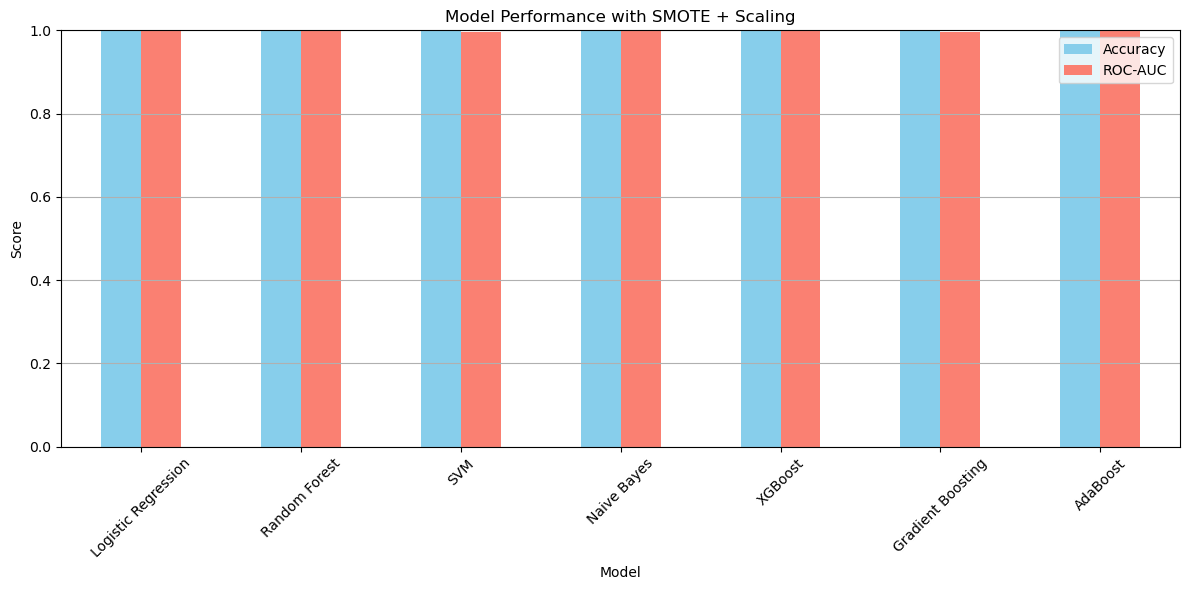

In [13]:
results_df = pd.DataFrame(results)
results_df.set_index("Model")[["Accuracy", "ROC-AUC"]].plot(kind='bar', figsize=(12, 6),color=["skyblue", "salmon"])
plt.title("Model Performance with SMOTE + Scaling")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()